### **一、分析原作者的WISDM.npz檔案組成**
* 論文：S. P. Singh, M. K. Sharma, A. Lay-Ekuakille, D. Gangwar and S. Gupta, "Deep ConvLSTM with self-attention for human activity decoding using wearable sensors," in IEEE Sensors Journal, doi: 10.1109/JSEN.2020.3045135.
* 論文程式碼：[Github](https://github.com/isukrit/encodingHumanActivity)  
* npz檔案：WISDM資料集，取樣頻率20Hz，共20846筆資料集，每1筆資料集約為5秒，包含有3軸加速度序列資料100筆
* 標籤：`walking`、`jogging`、`stairs`、`sitting`、`standing`、`kicking`

In [3]:
import numpy as np

# 讀取WISDM資料集的.npz檔案
npz_file_path = 'encodingHumanActivity-master/data/LOTO/WISDM.npz'
npz_data = np.load(npz_file_path, allow_pickle=True)

# 列出NPZ檔案中所有的鍵
list(npz_data.keys())

['y', 'X', 'folds']

In [8]:
# 提取資料
data_X_array = npz_data['X']  # (20846, 1, 100, 3): 共20846筆資料集，每1筆資料集有3軸加速度序列資料100筆
data_X_array = np.squeeze(data_X_array, axis = 1)
print("X: ", data_X_array.shape)

data_y_array = npz_data['y']
print("y: ", data_y_array.shape)

data_folds_array = npz_data['folds']
print("folds: ", data_folds_array.shape)
# print(data_folds_array)

X:  (20846, 100, 3)
y:  (20846, 6)
folds:  (10, 2)


Label:  2


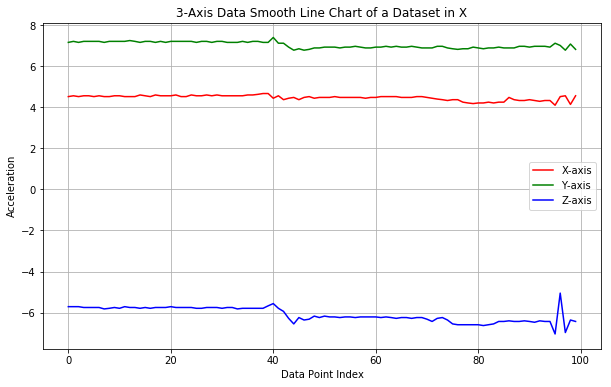

In [25]:
# 繪製資料分布
import matplotlib.pyplot as plt

# Select the first dataset for simplicity
dataset_index = 9000
dataset = data_X_array[dataset_index, :, :]  # This selects the first sequence, all 100 data sets, and all 3 axes

# Separate the data by axis
x_axis_data = dataset[:, 0]  # X-axis data
y_axis_data = dataset[:, 1]  # Y-axis data
z_axis_data = dataset[:, 2]  # Z-axis data

print("Label: ", np.argmax(data_y_array[dataset_index]))

# Create a smooth line chart for the 3-axis data
plt.figure(figsize=(10, 6))
plt.plot(x_axis_data, color='r', label='X-axis')
plt.plot(y_axis_data, color='g', label='Y-axis')
plt.plot(z_axis_data, color='b', label='Z-axis')
plt.title('3-Axis Data Smooth Line Chart of a Dataset in X')
plt.xlabel('Data Point Index')
plt.ylabel('Acceleration')
plt.legend()
plt.grid(True)
plt.show()

### **二、將UPB資料集做成.npz檔案**  
* 先運行 `convert_mat_to_csv_all.py` 將UPB資料集的.mat轉換為csv檔案
* 只將轉換完的電流與振動csv檔案做成.npz檔案(先取工況Operating Parameter為：N09_M07_F10)
* 訓練資料X的shape：(140, 250000, 3) --- 7個軸承編號，每個編號20個資料集，每個資料集包含振動訊號與2個電流訊號，資料數量為250000筆
* 訓練資料y的shape：(140, 3) --- 3種標籤
* 標籤：`Healthy`、`Outer ring damage`、`Inner ring damage`

In [ ]:
import pandas as pd
import numpy as np
import os

# 轉換所有訓練資料夾
folder_names = ['K002', 'KA01', 'KA05', 'KA07', 'KI01', 'KI05', 'KI07']
operating_parameter = 'N09_M07_F10'  # 指定工況
folder_indexes = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 
                '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']

# 定義空的y_onehot
y_data_array = np.zeros((140, 3))
data_index = 0

for folder_name in folder_names:
    for folder_index in folder_indexes:
        csv_file_path = os.path.join(folder_name, f'{operating_parameter}_{folder_name}_{folder_index}', 
                                     f'{operating_parameter}_{folder_name}_{folder_index}_current_vib.csv')
        # print(csv_file_path)
        df = pd.read_csv(csv_file_path)

        # 轉換為numpy數組
        X_data_array = df.to_numpy()

        # 減去後面幾個row以達到250000筆
        n_keep = 250000
        X_data_array = X_data_array[:n_keep]  # (250000, 3)
        # print(X_data_array.shape)

        # 變為3維陣列以方便堆疊
        X_data_array = np.expand_dims(X_data_array, axis=0)  # (1, 250000, 3)
        # print(X_data_array.shape)

        # 堆疊成為大陣列
        if data_index == 0:
            X_data_array_stack = np.copy(X_data_array)

        else:
            X_data_array_stack = np.concatenate((X_data_array_stack, X_data_array), axis=0)

        print("X_data_array_stack.shape: ", X_data_array_stack.shape)

        # 製作y_onehot: Healthy[1, 0, 0], Outer ring damage[0, 1, 0], Inner ring damage[0, 0, 1]
        if folder_name == 'K002':
            y_data_array[data_index, 0] = 1

        elif folder_name == 'KA01' or folder_name == 'KA05' or folder_name == 'KA07':
            y_data_array[data_index, 1] = 1

        elif folder_name == 'KI01' or folder_name == 'KI05' or folder_name == 'KI07':
            y_data_array[data_index, 2] = 1

        print("data_index {} processed.".format(data_index))

        data_index += 1

# 使用 savez_compressed 函數壓縮儲存到一個檔案，並為每個陣列指定一個key
npz_file_path = 'UPB_current_vib_N09_M07_F10_data.npz'
np.savez_compressed(npz_file_path, X=X_data_array_stack, y=y_data_array)

In [50]:
# 測試載入壓縮檔案
data = np.load('UPB_current_vib_N09_M07_F10_data.npz')

# 透過指定的key來存取陣列
arr1_loaded = data['X']
arr2_loaded = data['y']

print(arr1_loaded.shape)
print(arr2_loaded.shape)

(140, 250000, 3)
(140, 3)


### **三、讀取UPB的.npz檔案並丟入模型中訓練**  

##### **1. 導入必要的程式庫**

In [1]:
# 載入模型的Python檔案
import model_with_self_attn
from model_with_self_attn import model

import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score
import scipy.stats as st
import sys
import os
import random
import numpy as npz
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, Conv2D, Lambda, Input, Bidirectional, CuDNNLSTM, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras import backend as K
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from layers import Attention, SelfAttention
import keras
import datetime
from tqdm import tqdm, trange

Using TensorFlow backend.


##### **2. 定義模型參數**

In [3]:
# 定義模型儲存路徑
SAVE_DIR = './UPB_current_vib_N09_M07_F10_model'

# 創建模型儲存路徑資料夾
if not os.path.exists(os.path.join(SAVE_DIR)):
    os.mkdir(os.path.join(SAVE_DIR))

# 定義訓練參數
EPOCH = 5
BATCH_SIZE = 4
LSTM_UNITS = 32
CNN_FILTERS = 3
NUM_LSTM_LAYERS = 1
LEARNING_RATE = 1e-4
PATIENCE = 20
SEED = 0
F = 32  # attention length
D = 10

SEED = 200
random.seed(SEED)
np.random.seed(SEED)
tf.set_random_seed(SEED)

##### **3. 資料的預處理**

In [4]:
# 讀取UPB的.npz檔案
data_input_file = 'UPB_current_vib_N09_M07_F10_data.npz'
tmp = np.load(data_input_file, allow_pickle=True)
X = tmp['X']  # (140, 250000, 3)
y_one_hot = tmp['y']  # (140, 3)

# 將陣列中的資料順序做洗牌
indices = np.random.permutation(X.shape[0])  # 生成一個隨機的索引序列

# 使用這個索引序列來重新安排 X 和 y
X_shuffled = X[indices]
y_shuffled = y_one_hot[indices]

# print(X_shuffled.shape)  # (140, 250000, 3)
# print(y_shuffled.shape)  # (140, 3)

#===============================減少數據數量的方式===================================

# 方法一：使用切片進行降採樣：在第二維每隔10個點取一個點
# X_shuffled = X_shuffled[:, ::10, :]  # (140, 25000, 3)

# 方法二：使用RMS來減少數據長度：在第二維每隔5個點取RMS
# X_shuffled_rms = np.zeros((140, 50000, 3))  # 初始化一個空陣列來儲存RMS計算後的數據

# for i in trange(140, desc='RMS Processing'):  # 遍歷每個數據集
#     for j in range(3):  # 遍歷每個特徵
#         # 對於每個特徵，將數據分組，每10筆數據一組，並計算每組的RMS
#         for k in range(50000):  # 遍歷每組數據
#             # 提取當前組的數據
#             group = X_shuffled[i, k*5:(k+1)*5, j]
#             # 計算RMS並賦值
#             X_shuffled_rms[i, k, j] = np.sqrt(np.mean(np.square(group)))

# X_shuffled = np.copy(X_shuffled_rms)

# 方法三：使用Mean來減少數據長度：在第二維每隔10個點取Mean
# X_shuffled_mean = np.zeros((140, 50000, 3))  # 初始化一個空陣列來儲存平均值計算後的數據

# for i in trange(140, desc='Mean Processing'):  # 遍歷每個數據集
#     for j in range(3):  # 遍歷每個軸
#         # 對於每個軸，將數據分組，每10筆數據一組，並計算每組的平均值
#         for k in range(50000):  # 遍歷每組數據
#             # 提取當前組的數據
#             group = X_shuffled[i, k*5:(k+1)*5, j]
#             # 計算平均值並賦值
#             X_shuffled_mean[i, k, j] = np.mean(group)

# X_shuffled = np.copy(X_shuffled_mean)

# 方法四：使用FFT轉換
# X_shuffled_fft = np.zeros((140, 250000, 3), dtype=np.complex)  # 初始化一個空陣列來儲存FFT結果，注意FFT結果的大小與原數據相同

# for i in trange(140, desc='FFT Processing'):  # 遍歷每個數據集
#     for j in range(3):  # 遍歷每個軸
#         # 對每個軸的數據進行FFT轉換
#         X_shuffled_fft[i, :, j] = np.fft.fft(X_shuffled[i, :, j])

# X_shuffled = np.copy(np.abs(X_shuffled_fft))  # 幅度

# 方法五：採用0.25s的數據
X_shuffled = X_shuffled[:, 125000:140625, :]  # (140, 15625, 3)

#===================================================================================

print(X_shuffled.shape)  # (140, 25000, 3)

# 拆解成訓練集與驗證集
X_shuffled_val = np.copy(X_shuffled[120:])  # (20, 25000, 3)
y_shuffled_val = np.copy(y_shuffled[120:])  # (20, 3)
X_shuffled = X_shuffled[:120]  # (120, 25000, 3)
y_shuffled = y_shuffled[:120]  # (120, 3)
print("X_shuffled_val:{}, y_shuffled_val:{}, X_shuffled:{}, y_shuffled:{}".format(X_shuffled_val.shape, y_shuffled_val.shape, X_shuffled.shape, y_shuffled.shape))

NUM_LABELS = y_one_hot.shape[1]

y = np.argmax(y_shuffled, axis=1)

# 原作者： X_train_(18384, 100, 3, 1), y_train_one_hot(18384, 6)
X_shuffled_ = np.expand_dims(X_shuffled, axis = 3)  # (120, 25000, 3, 1)
X_shuffled_val_ = np.expand_dims(X_shuffled_val, axis = 3)  # (20, 25000, 3, 1)
# print(X_shuffled_.shape)

(140, 15625, 3)
X_shuffled_val:(20, 15625, 3), y_shuffled_val:(20, 3), X_shuffled:(120, 15625, 3), y_shuffled:(120, 3)


##### **4. 模型的輸入資料可視化**

Label: 0 (Healthy)


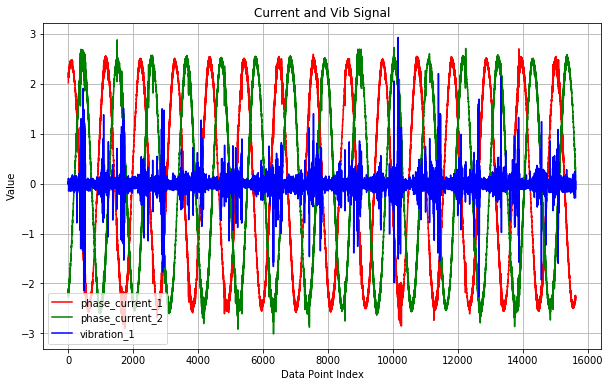

In [7]:
# 繪製資料分布
import matplotlib.pyplot as plt

# Select the first dataset for simplicity
dataset_index = 8  # 選擇隨機排列後的第幾筆資料
dataset = X_shuffled[dataset_index, :, :]

# Separate the data by axis
x_axis_data = dataset[:, 0]  # phase_current_1
y_axis_data = dataset[:, 1]  # phase_current_2
z_axis_data = dataset[:, 2]  # vibration_1

Label = ['Healthy', 'Outer ring damage', 'Inner ring damage']
print("Label: {} ({})".format(np.argmax(y_shuffled[dataset_index]), Label[np.argmax(y_shuffled[dataset_index])]))

# Create a smooth line chart for the 3-axis data
plt.figure(figsize=(10, 6))
plt.plot(x_axis_data, color='r', label='phase_current_1')
plt.plot(y_axis_data, color='g', label='phase_current_2')
plt.plot(z_axis_data, color='b', label='vibration_1')
plt.title('Current and Vib Signal')
plt.xlabel('Data Point Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

****(附加)若有FFT轉換：查看頻率與振幅關係圖****

Label: 2 (Inner ring damage)
feature:  vibration_1


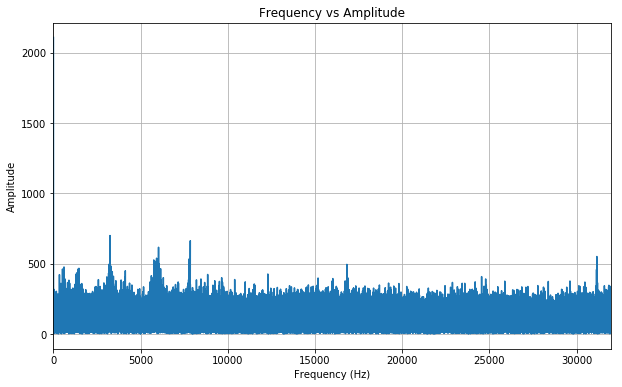

In [82]:
# 原始數據的採樣率，單位是Hz
sampling_rate = 64000

# 計算頻率軸的值
N = X_shuffled_fft.shape[1]  # 數據點的數量
freq = np.fft.fftfreq(N, d=1/sampling_rate)

dataset_index = 9  # 選擇要繪製的數據集
axis_index = 2  # 選擇要繪製的特徵
Label = ['Healthy', 'Outer ring damage', 'Inner ring damage']
feature = ['phase_current_1', 'phase_current_2', 'vibration_1']
print("Label: {} ({})".format(np.argmax(y_shuffled[dataset_index]), Label[np.argmax(y_shuffled[dataset_index])]))
print("feature: ", feature[axis_index])

# 計算選定數據和軸的FFT結果的幅度
magnitude = np.abs(X_shuffled_fft[dataset_index, :, axis_index])

# 繪製頻率與振幅的關係圖
plt.figure(figsize=(10, 6))
plt.plot(freq, magnitude)
plt.title('Frequency vs Amplitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim([0, sampling_rate / 2])  # 通常只顯示到Nyquist頻率
plt.grid(True)
plt.show()

##### **5. 開始訓練**

In [18]:
avg_acc = []
avg_recall = []
avg_f1 = []

# 創建模型
rnn_model = model(x_train = X_shuffled_, num_labels = NUM_LABELS, LSTM_units = LSTM_UNITS, \
    num_conv_filters = CNN_FILTERS, batch_size = BATCH_SIZE, F = F, D= D)

# 是否要載入現有模型權重以繼續訓練
model_path = os.path.join(SAVE_DIR, '_current_vib_N09_M07_F10_model_2024-02-21_08-56-05.h5')  # 想要載入的模型檔案名
if os.path.exists(model_path):
    print("載入現有模型繼續訓練")
    rnn_model.load_weights(model_path)
else:
    print("創建新模型進行訓練")

dt = datetime.datetime.now()

model_filename = SAVE_DIR + '/UPB_current_vib_N09_M07_F10_model_' + dt.strftime("%Y-%m-%d_%H-%M-%S") + '.h5'
callbacks = [ModelCheckpoint(filepath=model_filename, monitor = 'val_acc', save_weights_only=True, save_best_only=True), EarlyStopping(monitor='val_acc', patience=PATIENCE)]#, LearningRateScheduler()]

opt = optimizers.Adam(lr=LEARNING_RATE, clipnorm=1.)

rnn_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = rnn_model.fit(X_shuffled_, y_shuffled, epochs=EPOCH, batch_size=BATCH_SIZE, verbose=1, callbacks=callbacks, validation_data=(X_shuffled_val_, y_shuffled_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_inputs (InputLayer)      (4, 15625, 3, 1)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (4, 15625, 1, 1)          4         
_________________________________________________________________
lambda_1 (Lambda)            (4, 15625, 1)             0         
_________________________________________________________________
lstm (LSTM)                  [(4, 15625, 32), (4, 32), 4352      
_________________________________________________________________
self_attention_1 (SelfAttent [(4, 640), (4, 20, 15625) 1664      
_________________________________________________________________
dense_1 (Dense)              (4, 3)                    1923      
Total params: 7,943
Trainable params: 7,943
Non-trainable params: 0
_________________________________________________________________
None
創建新

In [15]:
# Evaluate model and predict data on TEST 
print("******Evaluating TEST set*********")
rnn_model.load_weights(model_filename)

y_test_predict = rnn_model.predict(X_shuffled_, batch_size = BATCH_SIZE)
y_test_predict = np.array(y_test_predict)
y_test_predict = np.argmax(y_test_predict, axis=1)

all_trainable_count = int(np.sum([K.count_params(p) for p in set(rnn_model.trainable_weights)]))

MAE = metrics.mean_absolute_error(y, y_test_predict, sample_weight=None, multioutput='uniform_average')

acc_fold = accuracy_score(y, y_test_predict)
avg_acc.append(acc_fold)

recall_fold = recall_score(y, y_test_predict, average='macro')
avg_recall.append(recall_fold)

f1_fold  = f1_score(y, y_test_predict, average='macro')
avg_f1.append(f1_fold)

print('Accuracy[{:.4f}] Recall[{:.4f}] F1[{:.4f}]'.format(acc_fold, recall_fold, f1_fold))
print('______________________________________________________')
K.clear_session()

ic_acc = st.t.interval(0.9, len(avg_acc) - 1, loc=np.mean(avg_acc), scale=st.sem(avg_acc))
ic_recall = st.t.interval(0.9, len(avg_recall) - 1, loc=np.mean(avg_recall), scale=st.sem(avg_recall))
ic_f1 = st.t.interval(0.9, len(avg_f1) - 1, loc = np.mean(avg_f1), scale=st.sem(avg_f1))

print('Mean Accuracy[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_acc), ic_acc[0], ic_acc[1]))
print('Mean Recall[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_recall), ic_recall[0], ic_recall[1]))
print('Mean F1[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_f1), ic_f1[0], ic_f1[1]))

******Evaluating TEST set*********
Accuracy[0.4500] Recall[0.3333] F1[0.2069]
______________________________________________________
Mean Accuracy[0.4500] IC [nan, nan]
Mean Recall[0.3333] IC [nan, nan]
Mean F1[0.2069] IC [nan, nan]


c:\ProgramData\Anaconda3\envs\EncodingHuman_py36\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
c:\ProgramData\Anaconda3\envs\EncodingHuman_py36\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\ProgramData\Anaconda3\envs\EncodingHuman_py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:2016: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)
